In [1]:
# @title Download all required libraries
install.packages("Seurat")
install.packages("dplyr")
install.packages("patchwork")
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
install.packages('caret')
install.packages('pROC')
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("scAnnotatR")#library(scRNAseq)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘dotCall64’, ‘gtools’, ‘caTools’, ‘plyr’, ‘tensor’, ‘BH’, ‘sitmo’, ‘sp’, ‘spam’, ‘globals’, ‘listenv’, ‘parallelly’, ‘zoo’, ‘lazyeval’, ‘crosstalk’, ‘RcppTOML’, ‘here’, ‘gplots’, ‘reshape2’, ‘gridExtra’, ‘RcppArmadillo’, ‘spatstat.data’, ‘spatstat.univar’, ‘spatstat.random’, ‘spatstat.utils’, ‘spatstat.sparse’, ‘goftest’, ‘abind’, ‘deldir’, ‘polyclip’, ‘FNN’, ‘dqrng’, ‘SeuratObject’, ‘cowplot’, ‘fastDummies’, ‘fitdistrplus’, ‘future’, ‘future.apply’, ‘ggrepel’, ‘ggridges’, ‘ica’, ‘igraph’, ‘irlba’, ‘leiden’, ‘lmtest’, ‘matrixStats’, ‘patchwork’, ‘pbapply’, ‘plotly’, ‘png’, ‘progressr’, ‘RANN’, ‘RcppAnnoy’, ‘RcppHNSW’, ‘reticulate’, ‘ROCR’, ‘RSpectra’, ‘Rtsne’, ‘scattermore’, ‘sctransform’, ‘spatstat.explore’, ‘spatstat.geom’, ‘uwot’, ‘RcppEigen’, ‘RcppProgress’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing packag

hdf5r (NA -> 1.3.11) [CRAN]


Installing 1 packages: hdf5r

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpMBpHW6/remotes116277d91ac/mojaveazure-seurat-disk-877d4e1/DESCRIPTION’ ... OK
* preparing ‘SeuratDisk’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘SeuratDisk_0.0.0.9021.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
# Import all libraries
library(dplyr)
library(patchwork)
library(Seurat)
library(ggplot2)
library(caret)    # For splitting data and training classifiers
library(pROC)     # For ROC curve and AUC
library(scAnnotatR)
library(lattice)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




In [3]:
# Load the dataset
single_cell.data <- readRDS("/content/PhD_test_obj.rds")
# Initialize the Seurat object with metadata
#str(single_cell.data) #check what is inside
single_cell <- CreateSeuratObject(counts = single_cell.data$count,
                                  project = "single_cells",
                                  meta.data = single_cell.data$metadata)
single_cell

An object of class Seurat 
27271 features across 43266 samples within 1 assay 
Active assay: RNA (27271 features, 0 variable features)
 1 layer present: counts

In [9]:
# @title Properties
# Check the available assays in the Seurat object
Assays(single_cell) #RNA
# List names of layers
layer_names <- names(single_cell@assays$RNA@layers)
print(layer_names) #counts
# Access a specific layer (e.g., counts)
counts_layer <- single_cell@assays$RNA@layers$counts
# # List all slots in the RNA assay
# slotNames(single_cell@assays$RNA) #'layers''cells''features''default''assay.orig''meta.data''misc''key'
# Check metadata structure
metadata <- single_cell@meta.data
print(head(metadata))

# # Try accessing the counts layer directly
# counts_layer <- single_cell@assays$RNA[["counts"]]
# print(dim(counts_layer))  # Check the dimensions of the counts layer
class(single_cell.data$count)
dim(single_cell.data$count)
class(single_cell.data$metadata)
dim(single_cell.data$metadata)




[1] "RNA"

[1] "counts"
                           orig.ident nCount_RNA nFeature_RNA
Disease_4-ACGGGTCCAATGCAGG    Disease      13027         3813
Disease_4-ACTATCTAGGGAGGTG    Disease      11683         3643
Disease_4-GCGAGAAAGGGTACAC    Disease      11141         3272
Disease_4-TCCCACACATGTCAGT    Disease      10822         3297
Disease_4-GACAGCCAGTTACGTC    Disease      10620         3269
Disease_4-GTCTACCTCTGTTGGA    Disease      10587         3439
                                              barcode               cell_type
Disease_4-ACGGGTCCAATGCAGG Disease_4-ACGGGTCCAATGCAGG Peripheral immune cells
Disease_4-ACTATCTAGGGAGGTG Disease_4-ACTATCTAGGGAGGTG Peripheral immune cells
Disease_4-GCGAGAAAGGGTACAC Disease_4-GCGAGAAAGGGTACAC Peripheral immune cells
Disease_4-TCCCACACATGTCAGT Disease_4-TCCCACACATGTCAGT Peripheral immune cells
Disease_4-GACAGCCAGTTACGTC Disease_4-GACAGCCAGTTACGTC Peripheral immune cells
Disease_4-GTCTACCTCTGTTGGA Disease_4-GTCTACCTCTGTTGGA Peripheral immune cells
       

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

[1] 27271 43266

[1] "data.frame"

[1] 43266     4

In [6]:
# @title Preprocessing
#Check QC metrics list
head(single_cell@meta.data,10)
#cols: orig.ident,	nCount_RNA,	nFeature_RNA,	barcode	cell_type,	label	replicate
#rows: genes
#Add Percentage of mitochondrial genes column to metadata
# single_cell[["percent.mt"]] <- PercentageFeatureSet(single_cell, pattern = "^MT-")
# single_cell[["percent.mt"]]
#percent mt is 0, as all genes are labeled starting with disease or control

,orig.ident,nCount_RNA,nFeature_RNA,barcode,cell_type,label,replicate
,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>
Disease_4-ACGGGTCCAATGCAGG,Disease,13027,3813,Disease_4-ACGGGTCCAATGCAGG,Peripheral immune cells,Disease,Disease_4
Disease_4-ACTATCTAGGGAGGTG,Disease,11683,3643,Disease_4-ACTATCTAGGGAGGTG,Peripheral immune cells,Disease,Disease_4
Disease_4-GCGAGAAAGGGTACAC,Disease,11141,3272,Disease_4-GCGAGAAAGGGTACAC,Peripheral immune cells,Disease,Disease_4
Disease_4-TCCCACACATGTCAGT,Disease,10822,3297,Disease_4-TCCCACACATGTCAGT,Peripheral immune cells,Disease,Disease_4
Disease_4-GACAGCCAGTTACGTC,Disease,10620,3269,Disease_4-GACAGCCAGTTACGTC,Peripheral immune cells,Disease,Disease_4
Disease_4-GTCTACCTCTGTTGGA,Disease,10587,3439,Disease_4-GTCTACCTCTGTTGGA,Peripheral immune cells,Disease,Disease_4
Disease_4-GACCTTCTCTCGCCTA,Disease,10489,3346,Disease_4-GACCTTCTCTCGCCTA,Peripheral immune cells,Disease,Disease_4
Disease_4-TGGTTAGGTGTACATC,Disease,10040,3147,Disease_4-TGGTTAGGTGTACATC,Peripheral immune cells,Disease,Disease_4
Disease_4-CAGAGCCAGCTTGTTG,Disease,9234,3302,Disease_4-CAGAGCCAGCTTGTTG,Peripheral immune cells,Disease,Disease_4


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


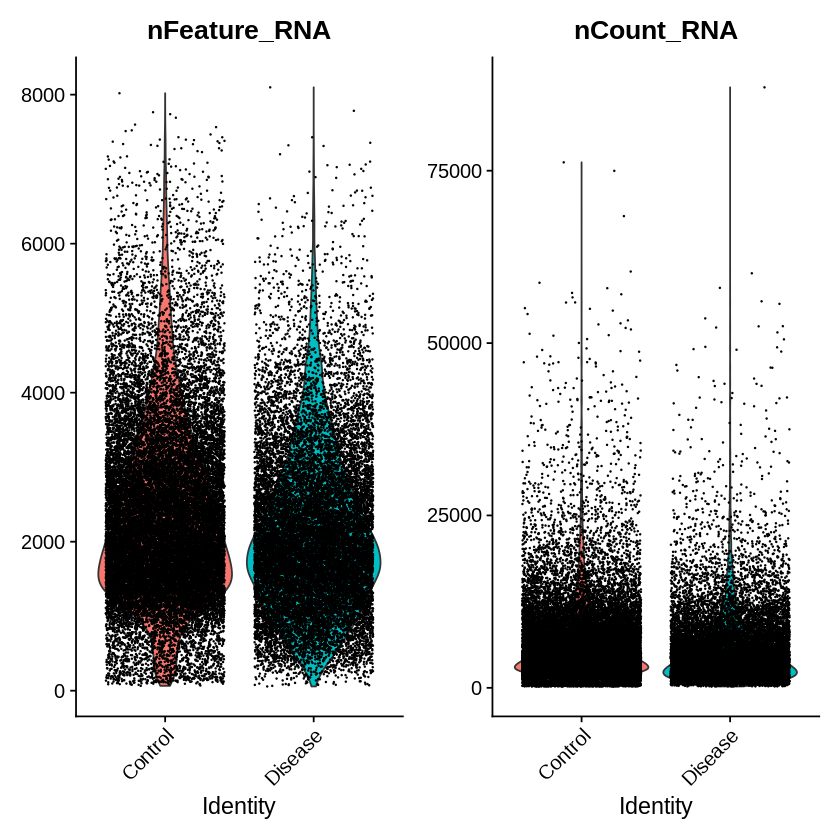

In [12]:
# @title
# Visualize QC metrics as a violin plot
VlnPlot(single_cell, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)


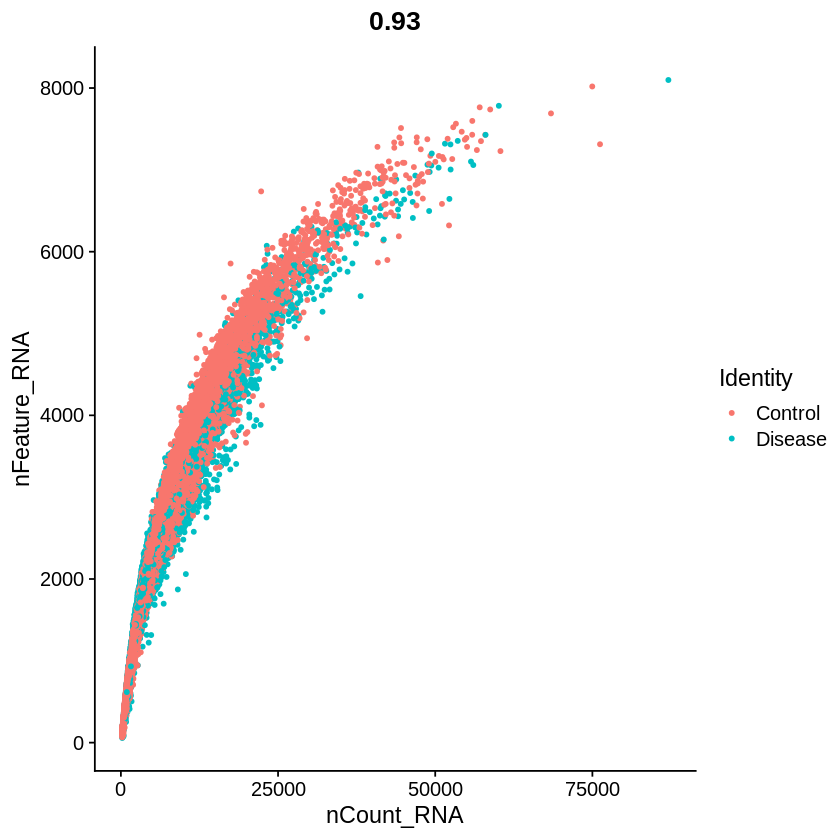

In [6]:
# @title
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.
plot1 <- FeatureScatter(single_cell, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1

In [4]:
#@title Preprocessing
# Filter cells that have unique feature counts over 2,500 or less than 200
single_cell_filtered <- subset(single_cell, subset = nFeature_RNA > 200 & nFeature_RNA < 2500)

# Normalise data
single_cell_filtered <- NormalizeData(single_cell_filtered)

# Identify high variable features
single_cell_filtered <- FindVariableFeatures(single_cell_filtered, selection.method = "vst", nfeatures = 2000)

# # Scale the data, not scaled due to limited RAM
single_cell_filtered <- ScaleData(single_cell_filtered)

# # Perform PCA on scaled data
single_cell_filtered <- RunPCA(single_cell_filtered)


Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  Tmeff2, Apod, Mal, A230001M10Rik, Scd2, 4930419G24Rik, Bcas1, Fth1, Lrmda, Gm37459 
	   Ptgds, Gsn, C030029H02Rik, Gm28376, Il33, Lgmn, A330015K06Rik, Plekha1, Enpp6, Cldn14 
	   Agmo, Inpp5d, Hexb, Fyb, Apbb1ip, Mob3b, Myo1f, Tgfbr1, Dock8, Itgb5 
Negative:  Fgf14, Nrxn1, Nrg3, Rbfox1, Asic2, Csmd1, Meg3, Ppp2r2b, Dlgap1, Kcnd2 
	   Lsamp, Fam155a, Lrrc7, Snhg11, Gria2, Rims2, Erc2, Ntm, Cntnap2, Rgs7 
	   Car10, Ptprn2, Syt1, Grm5, Gabrb3, Myt1l, Galnt13, Nrxn3, Tshz2, Sgcz 
PC_ 2 
Positive:  Pitpnc1, Rreb1, Apoe, Utrn, Itpkb, Cst3, Mertk, Fli1, Camk1d, Lpp 
	   Pid1, Itga6, Atp1a2, Sparc, Tmem164, Lyn, Cfh, Klf12, Inpp5d, Tgfbr2 
	   Zfhx3, Dock2, Runx1, Mef2c, Hexb, Tgfbr1, Fyb, Anxa3, Sirpa, Myo1f 
Negative:  Tmeff2, Cadm2, Dcc, Bcas1, Spock1, Nfasc, Xkr4, Grm7, Tenm2, Erbb4 
	   Lrrc4c, Mal, 4930419G24Rik, A330015K06Rik, Cntn3, Kcnab1, Pakap, A230001M10Rik, 

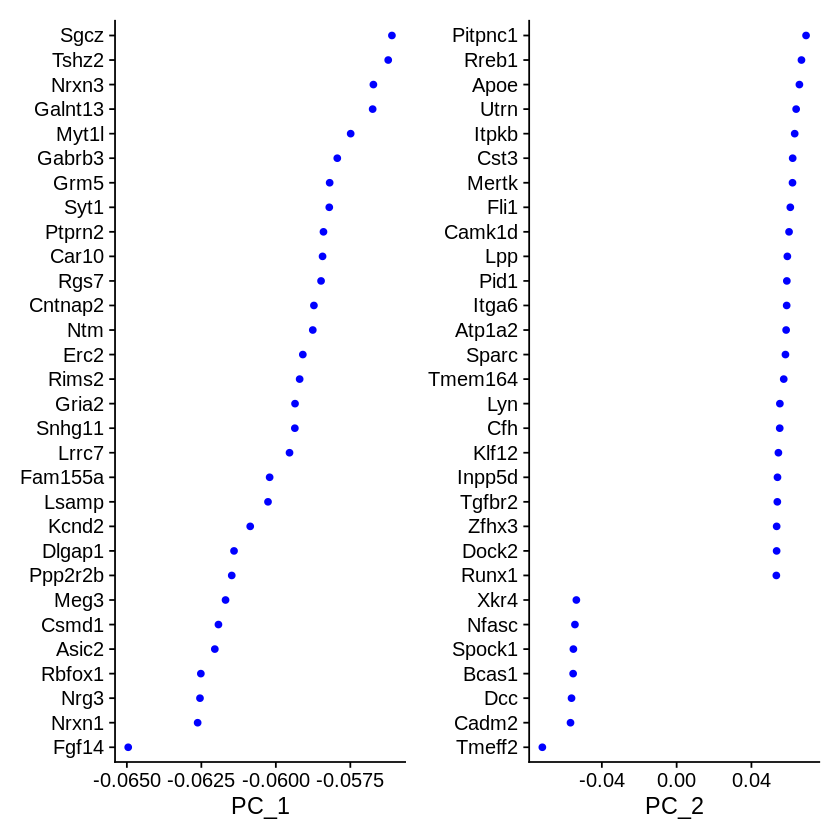

In [14]:
VizDimLoadings(single_cell_filtered, dims = 1:2, reduction = "pca")

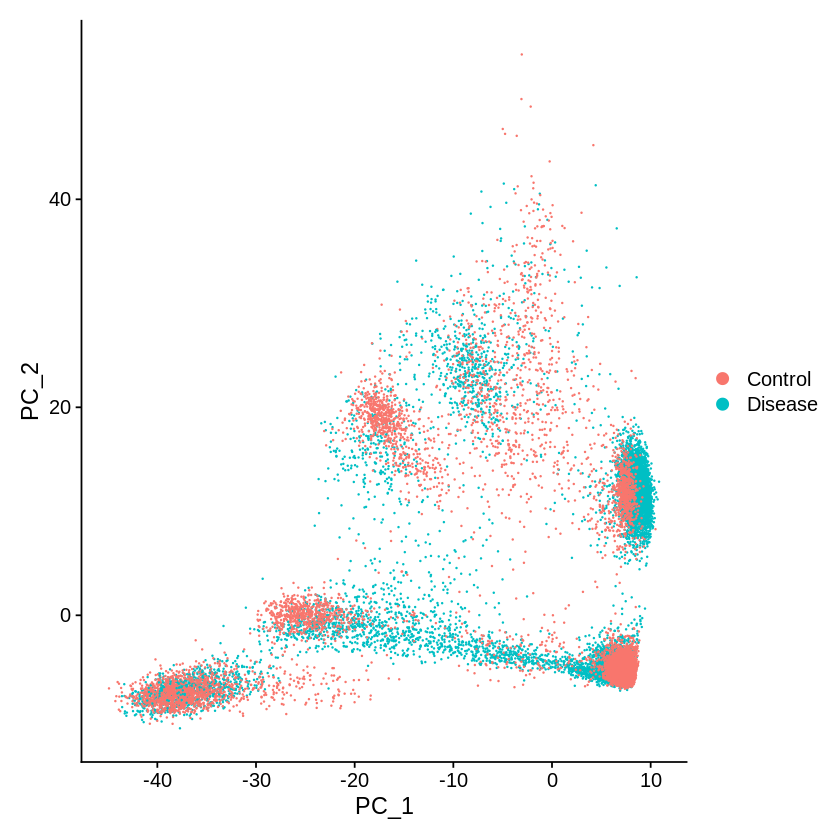

In [16]:
DimPlot(single_cell_filtered, reduction = "pca")

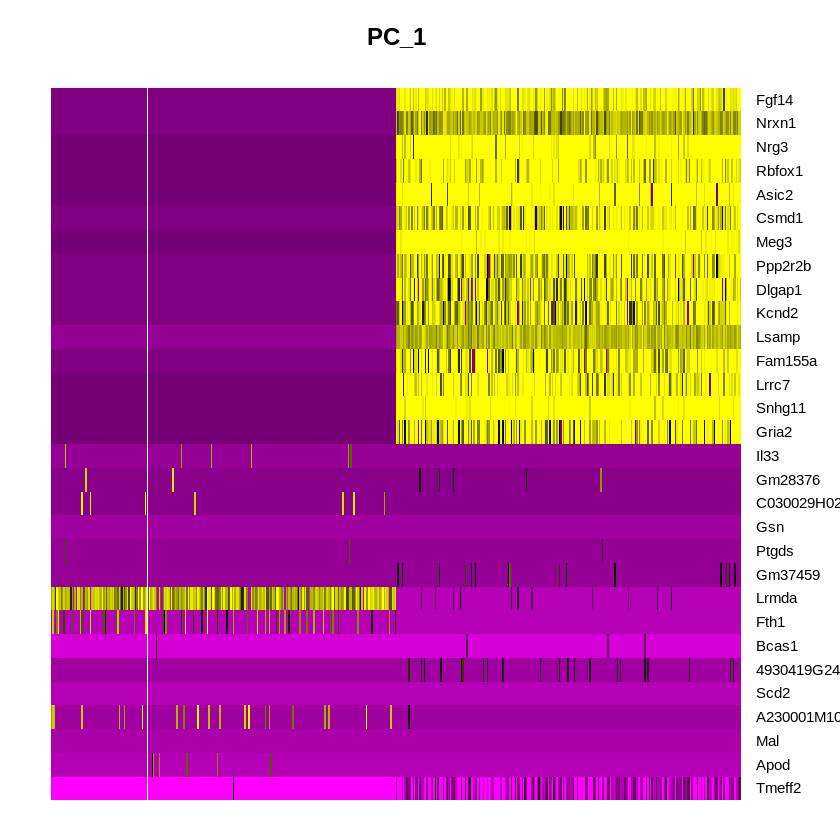

In [17]:
DimHeatmap(single_cell_filtered, dims = 1, cells = 500, balanced = TRUE)

In [5]:
# @title Task 1.1
# Identify the genes that are differentially expressed between the 2 conditions
# # Check unique cell types
# Idents(single_cell_filtered) <- "cell_type"  # Set cell type as identity class
# unique(Idents(single_cell_filtered))  # Display unique identities
#Myeloid, dividingPeripheral immune cellsMicrogliaNK, T cellsB cellsNewly formed oligodendrocytes (NFOL)Myelin forming oligodendrocytes (MFOL)Mature oligodendrocytes (MOL)Oligodendrocytes precursor cells (OPC)Vascular endothelial cellsVascular cellsAstrocytesEpendymal cellsDorsalVentral
#Check for condition
Idents(single_cell_filtered) <- "orig.ident"  # Set cell type as identity class
unique(Idents(single_cell_filtered))  # Display unique identities
group.markers <- FindMarkers(single_cell_filtered, ident.1 = "Control", ident.2 = "Disease")
# view results
head(group.markers)

[1] Disease Control
Levels: Control Disease

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Scd2,0,2.634501,0.717,0.232,0
Fth1,0,1.797720,0.682,0.224,0
4930419G24Rik,0,3.386258,0.599,0.143,0
Gm11149,0,2.804186,0.557,0.133,0
Lrrtm3,0,2.066090,0.647,0.225,0
Gm37459,0,3.795326,0.492,0.073,0


In [6]:
# @title Task 1.2
# Rank each cell type based on how much they are perturbed by the condition (from most perturbed to least perturbed)
# Findmarkers already returns the ranked list
disease.markers <- FindMarkers(single_cell_filtered, ident.1 = "Disease", ident.2 = NULL, only.pos = TRUE)
# view results
head(disease.markers)


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Fmn1,0,2.250777,0.590,0.226,0
Abca1,0,3.323676,0.513,0.169,0
Abr,0,2.530906,0.481,0.154,0
Ptprj,0,2.022040,0.501,0.205,0
Nav2,0,1.443322,0.660,0.370,0
Man1c1,0,2.855571,0.383,0.101,0


In [9]:
# @title Task 2.1
# split test and train dataset
ncol(single_cell_filtered)
pivot = ncol(single_cell_filtered) %/% 2
train_set <- single_cell_filtered[, 1:pivot]
test_set <- single_cell_filtered[, (1+pivot):ncol(single_cell_filtered)]
#dim(train_set)#27271,13824
# use top 15 disease markers
disease_markers<-head(rownames(disease.markers),15)
# Define train classifier
classifier_A <- train_classifier(train_obj = train_set, cell_type = "Disease",
                                 marker_genes = disease_markers,
                                 assay = 'RNA', tag_slot =  "orig.ident")
classifier_A

Loading required package: SingleCellExperiment

Warning message:
“replacing previous import ‘ape::where’ by ‘dplyr::where’ when loading ‘scAnnotatR’”


[1] 27648

An object of class scAnnotatR for Disease 
* 15 marker genes applied: Ptprj, Fmn1, Ophn1, Abca1, Man1c1, Arhgap24, Etv6, Nav2, Xylt1, Cacna1a, Abr, Cerk, Runx1, C4b, Piezo2 
* Predicting probability threshold: 0.5 
* No parent model

In [10]:
#Support Vector Machines with Linear Kernel
caret_model(classifier_A)
classifier_A_test <- test_classifier(classifier = classifier_A, test_obj = test_set,
                                     assay = 'RNA', tag_slot =  "orig.ident")


Support Vector Machines with Linear Kernel 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 12442, 12442, 12442, 12441, 12441, 12442, ... 
Addtional sampling using down-sampling

Resampling results:

  Accuracy  Kappa    
  0.860821  0.6533186

Tuning parameter 'C' was held constant at a value of 1

Current probability threshold: 0.5

 		Positive	Negative	Total

Actual		1975		11849		13824

Predicted	9191		4633		13824


Accuracy: 0.459056712962963


Sensivity (True Positive Rate) for Disease: 0.933670886075949

Specificity (1 - False Positive Rate) for Disease: 0.379947674909275

Area under the curve: 0.7857027725461



In [11]:
# Evaluation metrics
classifier_A_test$overall_roc
classifier_A_test$acc
classifier_A_test$auc

p_thres,fpr,tpr
0.1,0.9940079,0.9974684
0.2,0.9862436,0.9888608
0.3,0.7839480,0.9751899
0.4,0.7010718,0.9610127
0.5,0.6200523,0.9336709
0.6,0.5597941,0.9058228
0.7,0.4976791,0.8724051
0.8,0.4138746,0.8192405
0.9,0.2904043,0.7053165


[1] 0.4590567

Area under the curve: 0.7857

In [15]:
# @title Attempts to save it as h5ad file
# Install the Bioconductor rhdf5 package
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("rhdf5")
# Load the rhdf5 package
library(rhdf5)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Installing package(s) 'BiocVersion', 'rhdf5'

also installing the dependencies ‘Rhdf5lib’, ‘rhdf5filters’


Old packages: 'askpass', 'commonmark', 'credentials', 'sys', 'xfun'



In [36]:
# @title
# Load the reticulate library
library(reticulate)
install.packages("anndata")
library(anndata)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [20]:
# @title
# hfile <-Connect("single_cell.h5Seurat", mode = "r")
# #print(hfile)
# #Convert("single_cell.h5Seurat", dest = "h5ad")
# # Convert("single_cell.h5Seurat", assay = "RNA", dest = "h5ad") # same error
# # List the contents of the RNA assay to confirm that the counts layer exists
# hfile[["assays/RNA/layers"]]
# # Check for available datasets under the assays/RNA directory
# hfile[["assays/RNA"]]
# # List all available objects in the file
# h5ls("/content/single_cell.h5Seurat")
install.packages("anndata")

library(anndata)

# Load the Seurat object
single_cell <- LoadH5Seurat("/content/single_cell.h5Seurat")

# Create an AnnData object from the counts and metadata
# adata <- AnnData(
#     X = GetAssayData(single_cell, slot = "counts"),
#     obs = single_cell@meta.data,
#     var = single_cell@assays$RNA@features
# )

# Save the AnnData object to h5ad format
#adata$write("/content/single_cell.h5ad")


# Save as .h5Seurat file
SaveH5Seurat(single_cell, filename = "single_cell.h5Seurat")

# Convert .h5Seurat to .h5ad file
Convert("single_cell.h5Seurat", dest = "h5ad")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Validating h5Seurat file



ERROR: Error: Call assays must have either a 'counts' or 'data' slot, missing for RNA


In [4]:
# @title
# Save as .h5Seurat file
SaveH5Seurat(single_cell, filename = "single_cell.h5Seurat")

# Convert .h5Seurat to .h5ad file
Convert("single_cell.h5Seurat", dest = "h5ad")

Creating h5Seurat file for version 3.1.5.9900

Validating h5Seurat file

Adding data from RNA as X



ERROR: Error in assay.group$obj_copy_to(dst_loc = dfile, dst_name = "X", src_name = x.data): HDF5-API Errors:
    error #000: ../../../src/H5Ocopy.c in H5Ocopy(): line 233: unable to copy object
        class: HDF5
        major: Object header
        minor: Unable to copy object

    error #001: ../../../src/H5Ocopy.c in H5O__copy(): line 286: source object not found
        class: HDF5
        major: Symbol table
        minor: Object not found

    error #002: ../../../src/H5Gloc.c in H5G_loc_find(): line 420: can't find object
        class: HDF5
        major: Symbol table
        minor: Object not found

    error #003: ../../../src/H5Gtraverse.c in H5G_traverse(): line 848: internal path traversal failed
        class: HDF5
        major: Symbol table
        minor: Object not found

    error #004: ../../../src/H5Gtraverse.c in H5G__traverse_real(): line 624: traversal operator failed
        class: HDF5
        major: Symbol table
        minor: Callback failed

    error #005: ../../../src/H5Gloc.c in H5G__loc_find_cb(): line 376: object 'data' doesn't exist
       
